# Dataset de Segmentação de imagens


In [1]:
# Célula para baixar os dados. Execute apenas uma vez! Os dados são os mesmos
# dos utilizados nas aulas de classificação. Portanto provavelmente você não precisa
# baixar novamente. 
from torchvision.datasets.utils import download_and_extract_archive

def download(root):

    url_images = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'
    url_targets = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz'

    download_and_extract_archive(url_images, root, remove_finished=False)
    download_and_extract_archive(url_targets, root, remove_finished=False)

#download('../data/oxford_pets')

### Análise do dataset

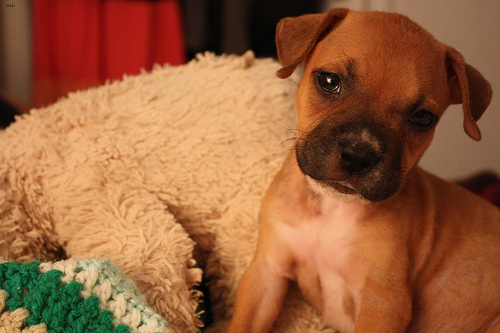

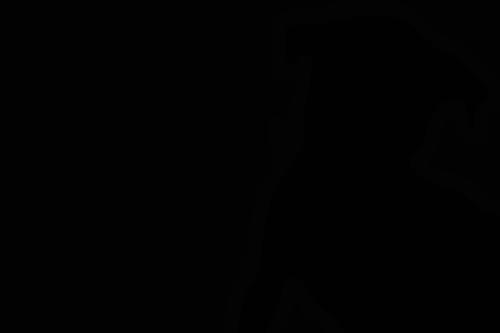

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset

root = Path('../data/oxford_pets')
img = Image.open(root/'images/boxer_22.jpg')
target = Image.open(root/'annotations/trimaps/boxer_22.png')

display(img, target)

A imagem de rótulos está toda preta! Isso acontece porque ela possui apenas os valores [1,2,3]. O pillow considera que os valores de intensidade estão entre [0,255], então ela é mostrada como se todos os píxeis fossem praticamente pretos

torch.uint8
tensor([1, 2, 3], dtype=torch.uint8)


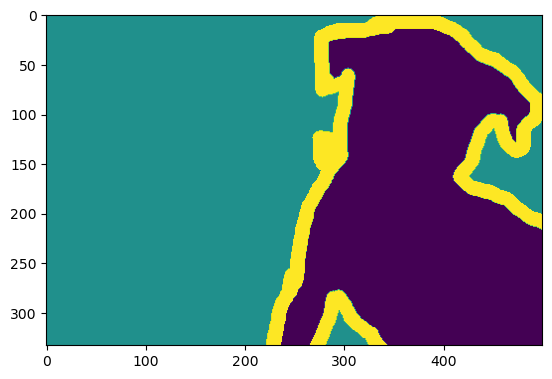

In [3]:
img = torch.from_numpy(np.array(img))/255
target = torch.from_numpy(np.array(target))
print(target.dtype)
print(torch.unique(target))
plt.imshow(target)

A imagem de rótulo possui 3 valores! Os valores possuem os seguintes significados:

* 1: Píxeis pertencentes ao objeto
* 2: Píxeis pertencentes ao fundo da imagem
* 3: Píxeis na região de borda do objeto. Esse píxeis não possuem classe definida, eles podem ser objeto ou fundo

É comum algoritmos considerarem que o valor 0 representa o fundo da imagem e o valor 1 o objeto, então teremos que mudar esses valores no nosso dataset. Adicionalmente, será importante no treinamento da rede ignorarmos os píxeis com valor 3, pois eles não possuem classe definida. 

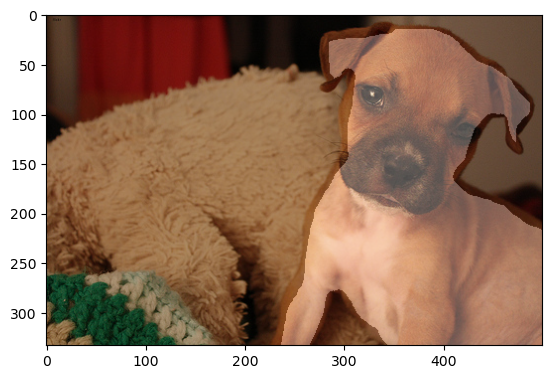

In [4]:
def show_mask(img, target, alpha=0.3):

    target_bin = (target==1).int()  # Cria imagem binária
    target_bin = target_bin.unsqueeze(2)  # Dimensão [H,W,1] para poder somar com a imagem
    mask = img*(1-alpha) + target_bin*alpha # Alpha blending
    plt.imshow(mask)

show_mask(img, target)

### Criação do dataset

A classe Dataset será muito parecida com a de classificação. Mas armazenaremos também os arquivos relacionados com os rótulos

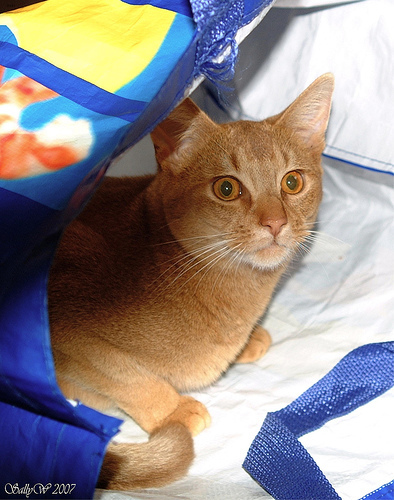

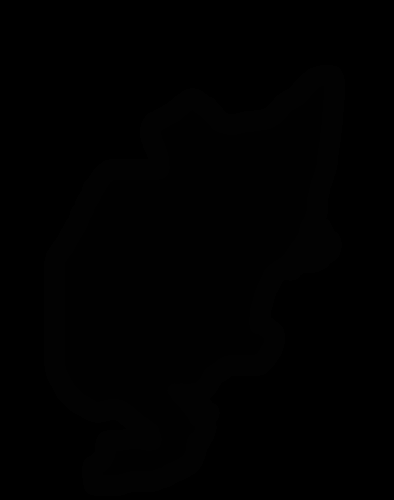

In [31]:
class OxfordIIITPetSeg(Dataset):

    def __init__(self, root, transforms=None, ignore_val=2):

        root = Path(root)
        images_folder = root / "images"
        segs_folder = root / "annotations/trimaps"
        anns_file = root / "annotations/list.txt"

        images = []
        segs = []
        for line in open(anns_file).read().splitlines():
            if line[0]!="#":   # Remove comentários do arquivo
                name, class_id, species_id, breed_id = line.strip().split()
                images.append(images_folder/f'{name}.jpg')
                segs.append(segs_folder/f'{name}.png')

        self.classes = ['Cat', 'Dog']
        self.images = images
        self.segs = segs
        self.transforms = transforms
        self.ignore_val = ignore_val

    def __getitem__(self, idx, apply_transform=True):

        # .convert("RGB") para garantir que as imagens são coloridas
        image = Image.open(self.images[idx]).convert("RGB")
        target_or = Image.open(self.segs[idx])

        # Muitos algoritmos esperam que o fundo tenha índice 0 e o objeto de interesse
        # possua valor 1. As imagens deste dataset possuem valores 1 para o objeto,
        # 2 para o fundo e 3 para píxeis indefinidos. Portanto, modificaremos os valores
        # 2->0 e 3->ignore_val
        target_np = np.array(target_or)
        target_np[target_np==2] = 0

        # Valor a ser usado para pixeis ignorados:
        if self.ignore_val!=3:
            target_np[target_np==3] = self.ignore_val

        # Padronizamos que um dataset retorna uma imagem pillow, então precisamos
        # converter novamente a imagem para esse formato
        target = Image.fromarray(target_np, mode="L")

        if self.transforms and apply_transform:
            image, target = self.transforms(image, target)

        return image, target
    
    def __len__(self):
        return len(self.images)

ds = OxfordIIITPetSeg(root)
display(*ds[0])

É útil verificarmos os tamanhos das imagens:

CPU times: user 422 ms, sys: 55 ms, total: 477 ms
Wall time: 381 ms


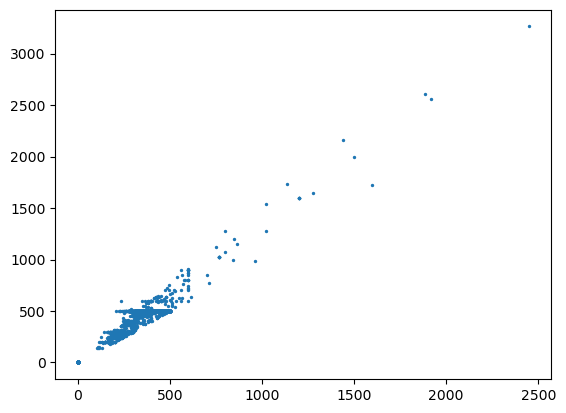

In [6]:
%%time
sizes = []
# Usamos o nome do arquivo ao invés de ds[idx] porque é mais rápido
for file in ds.images:  
    size = Image.open(file).size  
    sizes.append(size)
sizes = torch.tensor(sizes)
min_s = torch.min(sizes, axis=1)
max_s = torch.max(sizes, axis=1)
plt.scatter(min_s, max_s, s=2)

As imagens possuem razões de aspecto (divisão entre largura e altura) próximas de 1. Os tamanhos variam de ~100 a ~3000

Vamos também obter quantos píxeis pertencem ao fundo da imagem e quantos pertencem ao objeto:

In [7]:
%%time
# Esta célula demora para executar
npb = 0  # Nro de píxeis de fundo (background)
npo = 0  # Nro de píxeis de objeto
for img, target in ds:
    target = torch.from_numpy(np.array(target))
    npb += (target==0).sum()
    npo += (target==1).sum()

weights = (npo/(npo+npb), npb/(npb+npo))
print(npb, npo, weights)

tensor(758472669) tensor(380050806) (tensor(0.3338), tensor(0.6662))
CPU times: user 3min 28s, sys: 851 ms, total: 3min 29s
Wall time: 17.8 s


### Transformações

Em segmentação, precisamos tomar cuidado para não diminuir muito a imagem, pois isso pode fazer com que partes do objeto sumam da imagem. Por exemplo, se o objeto tiver uma parte muito fina com largura de 4 pixels, a redução do tamanho da imagem em mais de 4x gerará uma amostragem que pode não incluir essa parte.

Detalhe de implementação: as transformações do Pytorch precisam diferenciar entre tensores que representam imagens RGB ou nível de cinza e imagens que representam rótulos, isso é feito através de classes especiais que representam rótulos, bounding boxes, e outros tipos de estruturas.

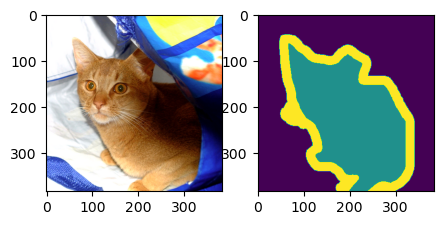

In [13]:
import  torchvision.transforms.v2 as transf
from torchvision import tv_tensors

class TransformsTrain:

    def __init__(self, resize_size=384):
    
        transforms = transf.Compose([
            transf.PILToTensor(),   
            transf.RandomResizedCrop(size=(resize_size,resize_size), scale=(0.5,1.), 
                                     ratio=(0.9,1.1), antialias=True),
            transf.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.01),
            transf.RandomHorizontalFlip(),
            transf.ToDtype({tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.int64}),
            # Transformação comentada para facilitar a visualização
            #transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.2, 58.4, 59.0))
        ])

        self.transforms = transforms

    def __call__(self, img, target):
        # Convertemos os tensores para os tipos Image e Mask para que as transformações 
        # tratem adequadamente as duas imagens. Por exemplo, não faz sentido modificar
        # o brilho da imagem de rótulo
        img = tv_tensors.Image(img)
        target = tv_tensors.Mask(target)
        img, target = self.transforms(img, target)
        # O atributo .data da classe Image possui o tensor que foi transformado
        img = img.data
        target = target.data
        # Remoção da dimensão de canal do target, pois as funções de loss esperam
        # um target de tamanho batch_size x altura x largura
        target = target.squeeze()
        return img, target
    
transforms = TransformsTrain()
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,3))
axs[0].imshow(img.permute(1, 2, 0)/255)
axs[1].imshow(target)


Para classificação, as transformações de validação incluíam um `CenterCrop`. Para segmentação, não podemos dar um crop, pois em geral queremos segmentar a imagem toda. Também não podemos tornar a imagem quadrada fazendo `Resize(size=(resize_size,resize_size))`, pois isso irá alterar os objetos da imagem.

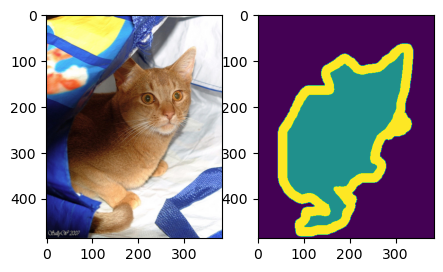

In [9]:
class TransformsEval:

    def __init__(self, resize_size=384):

        transforms = transf.Compose([
            transf.PILToTensor(),   
            transf.Resize(size=resize_size, antialias=True),
            transf.ToDtype({tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.int64}),
            #transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.2, 58.4, 59.0))
        ])

        self.transforms = transforms

    def __call__(self, img, target):
        img = tv_tensors.Image(img)
        target = tv_tensors.Mask(target)
        img, target = self.transforms(img, target)
        img = img.data
        target = target.data
        target = target.squeeze()
        return img, target

transforms = TransformsEval()
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,3))
axs[0].imshow(img.permute(1, 2, 0)/255)
axs[1].imshow(target)

Note que não dar crop na imagem de validação traz um problema! Não poderemos usar uma batch_size maior que 1 no dataloader de validação, pois imagens diferentes terão tamanhos diferentes. Portanto, teremos que criar uma collate_fn para adicionar padding nas imagens de forma que elas tenham o mesmo tamanho.

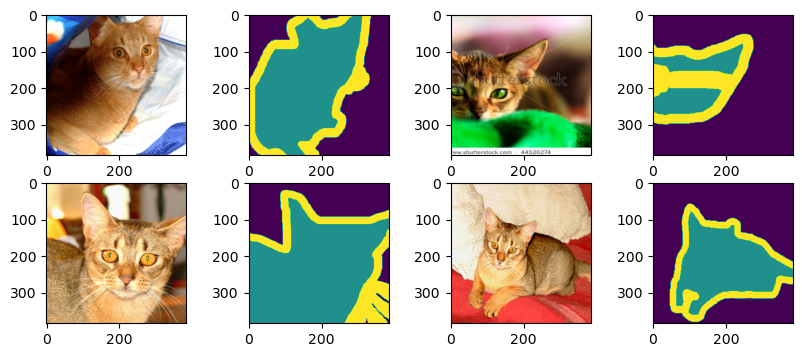

In [34]:
def cat_list(images, fill_value=0):
    '''Recebe uma lista de imagens e retorna um tensor com todas as imagens.
    É feito padding nas imagens para que elas tenham o mesmo tamanho.
    Note que a entrada da função pode ser um conjunto de imagens RGB ou um
    conjunto de targets que não possui canais.'''

    # Rótulos não possuem a dimensão de canal
    is_target = images[0].ndim==2

    num_rows, num_cols = zip(*[img.shape[-2:] for img in images])
    # Maior número de linhas e colunas entre todas as imagens no batch
    r_max, c_max = max(num_rows), max(num_cols)
    # Tamanho total do batch
    if is_target:
        batch_shape = (len(images), r_max, c_max)
    else:
        batch_shape = (len(images), 3, r_max, c_max)

    # Inserção de cada imagem dentro do batch
    batched_imgs = torch.full(batch_shape, fill_value, dtype=images[0].dtype)
    for idx in range(len(images)):
        img = images[idx]
        # Insere img na região de mesmo tamanho dentro do batch
        if is_target:
            batched_imgs[idx, :img.shape[0], :img.shape[1]] = img
        else:
            batched_imgs[idx, :, :img.shape[1], :img.shape[2]] = img

    return batched_imgs

def collate_fn(batch, img_fill=0, target_fill=2):
    '''Recebe uma lista de tuplas (imagem, target) e retorna um tensor com
    todas as imagens e outro com todos os targets.'''

    images, targets = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=img_fill)
    batched_targets = cat_list(targets, fill_value=target_fill)

    return batched_imgs, batched_targets

batch_list = [transforms(*ds[idx]) for idx in range(4)]
imgs, targets = collate_fn(batch_list)

fig, axs = plt.subplots(2, 4, figsize=(10,4))
axs = axs.reshape(-1)
for idx in range(4):
    axs[2*idx].imshow(imgs[idx].permute(1, 2, 0)/255)
    axs[2*idx+1].imshow(targets[idx])

O tamanho do batch é definido pela altura da imagem mais alta e largura da imagem mais larga daquele batch.